<a href="https://colab.research.google.com/github/Kubenew/ASI/blob/main/HRL6ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

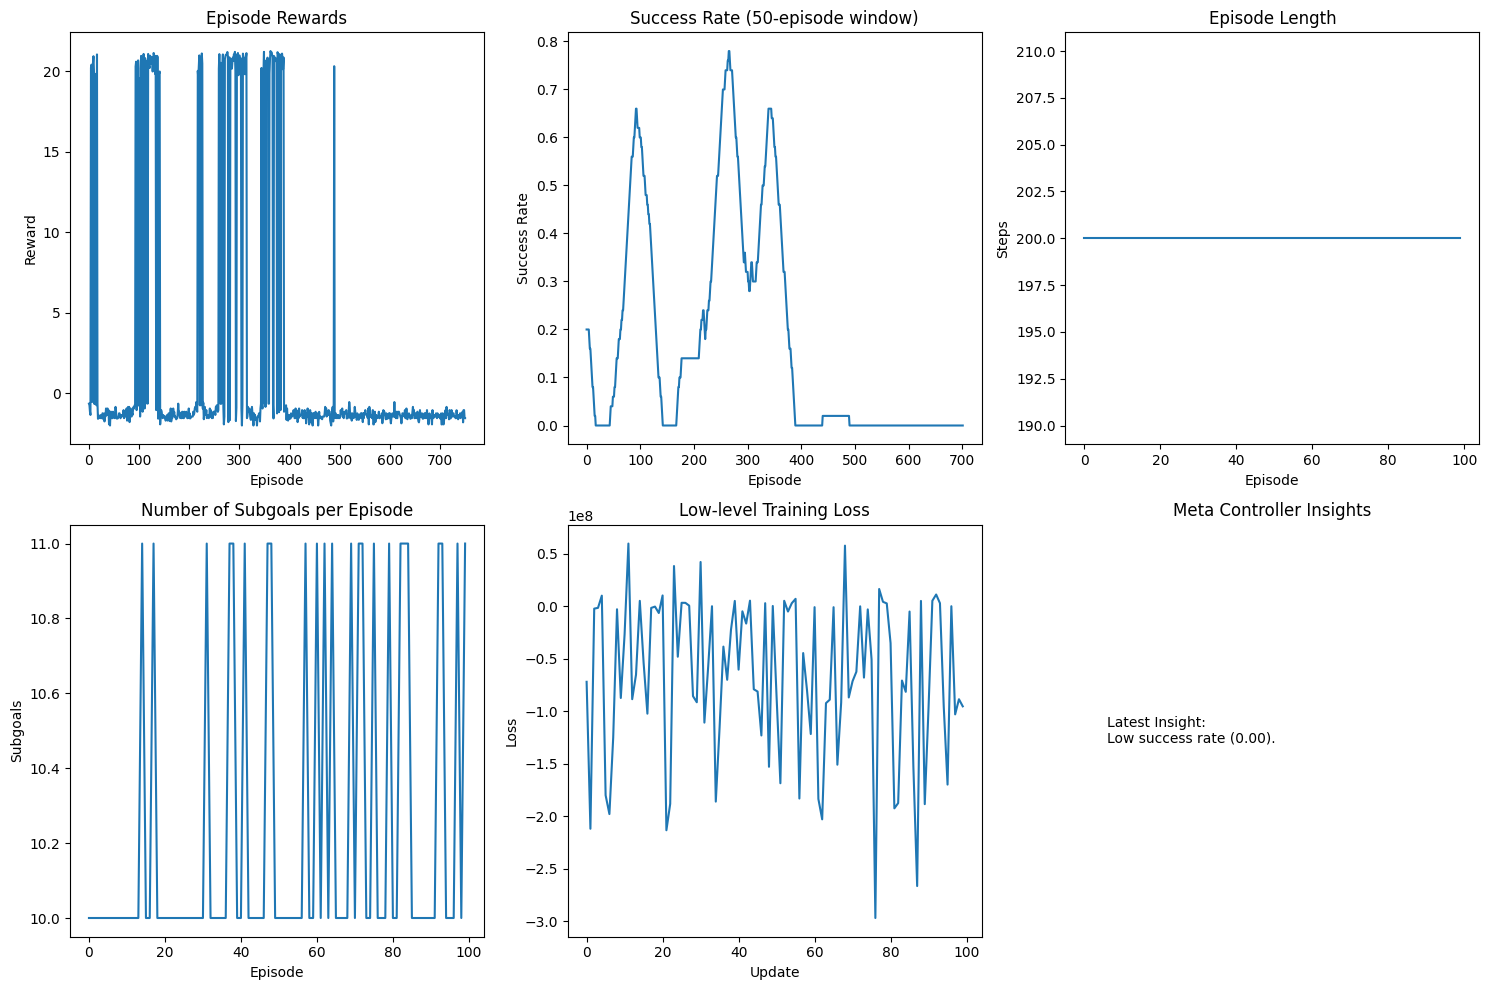

Episode 750/800
  Recent Avg Reward: -1.39
  Recent Success Rate: 0.0%
  Low-level Updates: 34100
  System Evolutions: 10
----------------------------------------

✓ Training completed!

FINAL SYSTEM ANALYSIS
Overall Success Rate: 16.0%

Most Common Subgoals:
  (np.int64(10), np.int64(10)): 2200 uses
  (np.int64(10), np.int64(0)): 505 uses
  (np.int64(4), np.int64(8)): 311 uses
  (np.int64(10), np.int64(6)): 284 uses
  (np.int64(4), np.int64(0)): 275 uses

Meta-evolution Events: 10
  Event 1: update_architecture
  Event 2: update_architecture
  Event 3: update_architecture
✓ System saved to /content/drive/MyDrive/hrl_system

TESTING FINAL SYSTEM

. . . . . . . . # . . .
. . . . . . . . . . . X
. . . . . . . . . . . .
. . . . . . # . . # # .
# . # . . . . . . . # .
. . . . # . . . . . . .
. . X # . . . . . . . .
. . . # . . . . . . . .
. . . . . . . . . . . .
. . X . # . . . # X . .
. . . . . . . X . . . .
. . A . . . . . . . . G
Steps: 100
Test 1: Fail

. . # . . . . . . . . .
. X . . 

In [ ]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque, defaultdict
import random
import copy
import hashlib
from IPython.display import clear_output, display
import pickle
import json

# =============================================================================
# 1. Улучшенное окружение с динамическими препятствиями
# =============================================================================
class DynamicGridWorldEnv(gym.Env):
    def __init__(self, size=12, config=None):
        super().__init__()
        self.size = size
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(
            low=0, high=size-1, shape=(2,), dtype=np.int32)

        self.config = config or {}
        self.obstacle_density = self.config.get('obstacle_density', 0.1)
        self.dynamic_obstacles = self.config.get('dynamic_obstacles', True)
        self.reset()

        # История для continual learning
        self.trajectory_history = []
        self.performance_history = []

    def reset(self):
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.array([self.size-1, self.size-1])

        # Статические препятствия
        self.static_obstacles = set()
        for i in range(self.size):
            for j in range(self.size):
                if random.random() < self.obstacle_density:
                    if not (i == 0 and j == 0) and not (i == self.size-1 and j == self.size-1):
                        self.static_obstacles.add((i, j))

        # Динамические препятствия
        self.dynamic_obs = set()
        if self.dynamic_obstacles:
            for _ in range(5):
                self.dynamic_obs.add(
                    (random.randint(0, self.size-1), random.randint(0, self.size-1))
                )

        self.steps = 0
        self.max_steps = 500
        return self._get_obs()

    def _get_obs(self):
        # Расширенное наблюдение с информацией о препятствиях
        obs = np.array(self.agent_pos, dtype=np.float32)

        # Добавляем информацию о ближайших препятствиях
        obstacle_feats = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                check_pos = (self.agent_pos[0] + dx, self.agent_pos[1] + dy)
                is_obstacle = int(check_pos in self.static_obstacles or
                                  check_pos in self.dynamic_obs)
                obstacle_feats.append(is_obstacle)

        return np.concatenate([obs, obstacle_feats])

    def step(self, action):
        self.steps += 1
        old_pos = self.agent_pos.copy()

        # Действия с небольшим стохастизмом (симулируя неопределенность)
        if random.random() < 0.05:  # 5% шанс на ошибку
            action = random.choice([0, 1, 2, 3])

        # Движение
        if action == 0:  # up
            self.agent_pos[0] = max(0, self.agent_pos[0]-1)
        elif action == 1:  # down
            self.agent_pos[0] = min(self.size-1, self.agent_pos[0]+1)
        elif action == 2:  # left
            self.agent_pos[1] = max(0, self.agent_pos[1]-1)
        elif action == 3:  # right
            self.agent_pos[1] = min(self.size-1, self.agent_pos[1]+1)

        # Проверка препятствий
        if (tuple(self.agent_pos) in self.static_obstacles or
            tuple(self.agent_pos) in self.dynamic_obs):
            self.agent_pos = old_pos  # отскок
            reward = -0.5
            collision = True
        else:
            collision = False

        # Награды
        if np.array_equal(self.agent_pos, self.goal_pos):
            reward = 20.0
            done = True
            success = True
        elif self.steps >= self.max_steps:
            reward = -5.0
            done = True
            success = False
        else:
            # Прогресс к цели
            old_dist = np.linalg.norm(old_pos - self.goal_pos)
            new_dist = np.linalg.norm(self.agent_pos - self.goal_pos)
            progress = old_dist - new_dist

            # Базовые награды
            reward = progress * 0.1 - 0.01  # шаговый штраф
            done = False
            success = False

        # Обновление динамических препятствий
        if self.dynamic_obstacles and random.random() < 0.02:
            if len(self.dynamic_obs) > 0 and random.random() < 0.3:
                self.dynamic_obs.pop()
            else:
                new_obs = (random.randint(0, self.size-1), random.randint(0, self.size-1))
                if new_obs not in self.static_obstacles:
                    self.dynamic_obs.add(new_obs)

        # Сохраняем траекторию для continual learning
        self.trajectory_history.append({
            'state': self._get_obs(),
            'action': action,
            'reward': reward,
            'next_state': self._get_obs(),
            'done': done
        })

        return self._get_obs(), reward, done, {
            'success': success,
            'collision': collision,
            'progress': progress if 'progress' in locals() else 0
        }

    def render(self, mode='human'):
        grid = np.zeros((self.size, self.size))
        grid[self.agent_pos[0], self.agent_pos[1]] = 2
        grid[self.goal_pos[0], self.goal_pos[1]] = 3
        for obs in self.static_obstacles:
            grid[obs[0], obs[1]] = -1
        for obs in self.dynamic_obs:
            grid[obs[0], obs[1]] = -2

        if mode == 'human':
            print("\n" + "="*30)
            for i in range(self.size):
                row = []
                for j in range(self.size):
                    val = grid[i, j]
                    if val == 2:
                        row.append("A")
                    elif val == 3:
                        row.append("G")
                    elif val == -1:
                        row.append("#")
                    elif val == -2:
                        row.append("X")
                    else:
                        row.append(".")
                print(" ".join(row))
            print(f"Steps: {self.steps}")
        return grid

# =============================================================================
# 2. Нейросетевой Low-level контроллер (Actor-Critic)
# =============================================================================
class LowLevelActorCritic(nn.Module):
    """Улучшенный низкоуровневый контроллер с архитектурой Actor-Critic"""

    def __init__(self, state_dim=11, action_dim=4, subgoal_dim=2,
                 hidden_dim=128, config=None):
        super().__init__()
        self.config = config or {}

        # Общая часть для извлечения признаков
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim + subgoal_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor (политика)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

        # Critic (функция ценности)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Оптимизатор
        self.optimizer = optim.Adam(self.parameters(),
                                   lr=self.config.get('ll_lr', 0.001))

        # Replay buffer для off-policy обучения
        self.buffer = deque(maxlen=10000)
        self.batch_size = self.config.get('ll_batch_size', 64)

        # Для отслеживания производительности
        self.training_history = []
        self.entropy_coef = 0.01

    def forward(self, state, subgoal):
        # Конкатенируем состояние и суб-цель
        x = torch.cat([state, subgoal], dim=-1)
        features = self.feature_extractor(x)

        # Политика и значение
        action_logits = self.actor(features)
        value = self.critic(features)

        return action_logits, value

    def get_action(self, state, subgoal, epsilon=0.1, training=True):
        """Получить действие с exploration"""
        state_t = torch.FloatTensor(state).unsqueeze(0)
        subgoal_t = torch.FloatTensor(subgoal).unsqueeze(0)

        with torch.no_grad():
            action_logits, _ = self.forward(state_t, subgoal_t)
            probs = F.softmax(action_logits, dim=-1)

        if training and random.random() < epsilon:
            action = random.randint(0, 3)
        else:
            if training:
                # Используем вероятностный выбор
                action = torch.multinomial(probs, 1).item()
            else:
                # Жадный выбор
                action = torch.argmax(probs).item()

        return action, probs[0, action].item()

    def store_transition(self, state, subgoal, action, reward, next_state, done):
        """Сохранить переход в replay buffer"""
        self.buffer.append({
            'state': state,
            'subgoal': subgoal,
            'action': action,
            'reward': reward,
            'next_state': next_state,
            'done': done
        })

    def update(self):
        """Обновить политику с помощью A2C"""
        if len(self.buffer) < self.batch_size:
            return 0

        # Выборка из буфера
        batch = random.sample(self.buffer, self.batch_size)

        states = torch.FloatTensor([b['state'] for b in batch])
        subgoals = torch.FloatTensor([b['subgoal'] for b in batch])
        actions = torch.LongTensor([b['action'] for b in batch])
        rewards = torch.FloatTensor([b['reward'] for b in batch])
        next_states = torch.FloatTensor([b['next_state'] for b in batch])
        dones = torch.FloatTensor([b['done'] for b in batch])

        # Forward pass
        action_logits, values = self.forward(states, subgoals)
        _, next_values = self.forward(next_states, subgoals)

        # Преобразуем в вероятности
        probs = F.softmax(action_logits, dim=-1)
        log_probs = F.log_softmax(action_logits, dim=-1)

        # Выбранные логиты
        action_log_probs = log_probs.gather(1, actions.unsqueeze(1)).squeeze()

        # Advantage calculation
        advantages = rewards + 0.99 * next_values.squeeze() * (1 - dones) - values.squeeze()

        # Policy loss
        policy_loss = -(action_log_probs * advantages.detach()).mean()

        # Value loss
        value_loss = F.mse_loss(values.squeeze(), rewards + 0.99 * next_values.squeeze() * (1 - dones))

        # Entropy regularization
        entropy = -(probs * log_probs).sum(dim=-1).mean()

        # Total loss
        loss = policy_loss + 0.5 * value_loss - self.entropy_coef * entropy

        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), 0.5)
        self.optimizer.step()

        # Сохраняем историю
        self.training_history.append({
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'entropy': entropy.item(),
            'total_loss': loss.item()
        })

        return loss.item()

    def get_performance_metrics(self):
        """Получить метрики производительности"""
        if not self.training_history:
            return {}

        recent = self.training_history[-100:]  # Последние 100 обновлений
        return {
            'avg_loss': np.mean([h['total_loss'] for h in recent]),
            'avg_entropy': np.mean([h['entropy'] for h in recent]),
            'policy_loss': recent[-1]['policy_loss'] if recent else 0,
            'n_updates': len(self.training_history)
        }

# =============================================================================
# 3. High-level политика с Continual Learning
# =============================================================================
class HighLevelPolicy(nn.Module):
    """Высокоуровневая политика с адаптивным выбором суб-целей"""

    def __init__(self, state_dim=11, subgoal_dim=2, hidden_dim=256,
                 num_subgoals=36, config=None):
        super().__init__()

        self.config = config or {}
        self.subgoal_dim = subgoal_dim
        self.num_subgoals = num_subgoals

        # Основная сеть для выбора суб-целей
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_subgoals)
        )

        # Сеть для предсказания достижимости суб-целей
        self.reachability_predictor = nn.Sequential(
            nn.Linear(state_dim + subgoal_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

        # Память для continual learning
        self.subgoal_memory = deque(maxlen=1000)
        self.subgoal_performance = {}
        self.adaptive_subgoals = self._initialize_subgoals()

        # История для адаптации
        self.selection_history = []
        self.optimizer = optim.Adam(self.parameters(),
                                   lr=self.config.get('hl_lr', 0.0005))

        # Счетчик для динамического обновления суб-целей
        self.update_counter = 0
        self.subgoal_update_freq = self.config.get('subgoal_update_freq', 50)

    def _initialize_subgoals(self):
        """Инициализация набора суб-целей"""
        subgoals = []
        grid_size = int(np.sqrt(self.num_subgoals))

        # Равномерная сетка
        for i in range(grid_size):
            for j in range(grid_size):
                x = i * (10 / (grid_size - 1)) if grid_size > 1 else 5
                y = j * (10 / (grid_size - 1)) if grid_size > 1 else 5
                subgoals.append(np.array([x, y], dtype=np.float32))

        return subgoals

    def forward(self, state):
        return self.net(state)

    def predict_reachability(self, state, subgoal):
        """Предсказать вероятность достижения суб-цели"""
        state_t = torch.FloatTensor(state).unsqueeze(0)
        subgoal_t = torch.FloatTensor(subgoal).unsqueeze(0)
        input_t = torch.cat([state_t, subgoal_t], dim=-1)
        return self.reachability_predictor(input_t).item()

    def select_subgoal(self, state, epsilon=0.15, use_adaptive=True):
        """Выбрать суб-цель с учетом history и reachability"""
        state_t = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            logits = self.forward(state_t)
            probs = F.softmax(logits, dim=-1).squeeze().numpy()

        # Exploration
        if random.random() < epsilon:
            idx = random.randint(0, self.num_subgoals - 1)
        else:
            # Учитываем предсказанную достижимость
            if use_adaptive:
                adjusted_probs = probs.copy()
                for i, subgoal in enumerate(self.adaptive_subgoals):
                    reachability = self.predict_reachability(state, subgoal)
                    adjusted_probs[i] *= (0.3 + 0.7 * reachability)  # Взвешиваем

                idx = np.random.choice(len(adjusted_probs), p=adjusted_probs/np.sum(adjusted_probs))
            else:
                idx = np.random.choice(len(probs), p=probs/np.sum(probs))

        selected_subgoal = self.adaptive_subgoals[idx].copy()

        # Запоминаем выбор
        self.selection_history.append({
            'state': state.copy(),
            'subgoal_idx': idx,
            'subgoal': selected_subgoal.copy(),
            'step': len(self.selection_history)
        })

        return selected_subgoal, idx

    def update_subgoals(self, performance_data):
        """Адаптация суб-целей на основе производительности"""
        self.update_counter += 1

        if self.update_counter % self.subgoal_update_freq != 0:
            return

        # Анализ успешных суб-целей
        successful_subgoals = []
        for data in performance_data[-100:]:  # Последние 100 эпизодов
            if data.get('success_rate', 0) > 0.7:
                for sg in data.get('subgoals_used', []):
                    successful_subgoals.append(sg)

        if not successful_subgoals:
            return

        # Кластеризация успешных суб-целей (упрощенная)
        successful_subgoals = np.array(successful_subgoals)
        if len(successful_subgoals) > 5:
            # Находим центры кластеров
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=min(10, len(successful_subgoals)//5))
            kmeans.fit(successful_subgoals)

            # Обновляем некоторые суб-цели
            for i, center in enumerate(kmeans.cluster_centers_[:5]):
                replace_idx = random.randint(0, self.num_subgoals - 1)
                self.adaptive_subgoals[replace_idx] = center.astype(np.float32)

        print(f"[HL] Updated {min(5, len(successful_subgoals)//10)} subgoals based on performance")

    def update_policy(self, advantages):
        """Обновить политику через policy gradient"""
        if not self.selection_history:
            return 0

        # Подготовка данных
        states = []
        indices = []

        for i, record in enumerate(self.selection_history[-100:]):  # Последние 100 выборов
            if i < len(advantages):
                states.append(record['state'])
                indices.append(record['subgoal_idx'])

        if not states:
            return 0

        states_t = torch.FloatTensor(states)
        indices_t = torch.LongTensor(indices)

        # Forward pass
        logits = self.forward(states_t)
        log_probs = F.log_softmax(logits, dim=-1)

        # Выбранные логиты
        selected_log_probs = log_probs.gather(1, indices_t.unsqueeze(1)).squeeze()

        # Policy loss (REINFORCE)
        advantages_t = torch.FloatTensor(advantages[-len(states):])
        policy_loss = -(selected_log_probs * advantages_t).mean()

        # Обновление
        self.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
        self.optimizer.step()

        # Очистка истории
        self.selection_history = []

        return policy_loss.item()

# =============================================================================
# 4. Meta-Controller для рекурсивного самоулучшения
# =============================================================================
class MetaController:
    """Мета-контроллер для оценки и улучшения всей системы"""

    def __init__(self, config=None):
        self.config = config or {}
        self.memory = deque(maxlen=1000)

        # Архитектурные варианты для low-level
        self.architectures = [
            {'hidden_dim': 64, 'layers': 2},
            {'hidden_dim': 128, 'layers': 2},
            {'hidden_dim': 256, 'layers': 3},
            {'hidden_dim': 128, 'layers': 4},
        ]

        # Текущая конфигурация
        self.current_arch_idx = 0
        self.performance_history = []
        self.architecture_performance = defaultdict(list)

        # Анализ траекторий
        self.trajectory_analyzer = TrajectoryAnalyzer()

        # Механизм рефлексии
        self.reflection_buffer = deque(maxlen=100)

        # Система для генерации кода (символический)
        self.code_generator = CodeGenerator()

    def analyze_system_performance(self, env, hl_policy, ll_controller, episode_data):
        """Анализ производительности системы"""
        analysis = {
            'success_rate': np.mean([e.get('success', False) for e in episode_data[-50:]]),
            'avg_steps': np.mean([e.get('steps', 0) for e in episode_data[-50:]]),
            'avg_reward': np.mean([e.get('reward', 0) for e in episode_data[-50:]]),
            'll_performance': ll_controller.get_performance_metrics(),
            'subgoal_efficiency': self._analyze_subgoal_efficiency(episode_data),
            'bottlenecks': self._identify_bottlenecks(env.trajectory_history[-100:])
        }

        self.performance_history.append(analysis)

        # Рефлексия: записываем insights
        if analysis['success_rate'] < 0.3:
            insight = f"Low success rate ({analysis['success_rate']:.2f}). "
            if analysis['bottlenecks'].get('collision_rate', 0) > 0.3:
                insight += "High collision rate detected. "
            if analysis['subgoal_efficiency'].get('useless_rate', 0) > 0.4:
                insight += "Many subgoals are not useful. "

            self.reflection_buffer.append({
                'episode': len(self.performance_history),
                'insight': insight,
                'suggested_actions': self._generate_suggestions(analysis)
            })

        return analysis

    def _analyze_subgoal_efficiency(self, episode_data):
        """Анализ эффективности суб-целей"""
        if not episode_data:
            return {}

        recent = episode_data[-20:]
        efficiency_metrics = []

        for ep in recent:
            if 'subgoal_history' in ep:
                history = ep['subgoal_history']
                if len(history) > 1:
                    # Измеряем прогресс на суб-цель
                    progresses = []
                    for i in range(len(history)-1):
                        sg1 = history[i]['subgoal']
                        sg2 = history[i+1]['subgoal']
                        progress = np.linalg.norm(sg1 - sg2)
                        progresses.append(progress)

                    if progresses:
                        efficiency_metrics.append(np.mean(progresses))

        if not efficiency_metrics:
            return {'avg_progress': 0, 'useless_rate': 0}

        avg_progress = np.mean(efficiency_metrics)
        useless_rate = np.mean([1 if p < 0.5 else 0 for p in efficiency_metrics])

        return {
            'avg_progress': avg_progress,
            'useless_rate': useless_rate
        }

    def _identify_bottlenecks(self, trajectories):
        """Идентификация узких мест в системе"""
        if not trajectories:
            return {}

        collisions = 0
        stuck_states = 0

        for traj in trajectories:
            if traj.get('collision', False):
                collisions += 1

            # Проверка на "застревание" (повторяющиеся состояния)
            if len(traj.get('state_history', [])) > 10:
                last_states = traj['state_history'][-10:]
                if len(set(tuple(s) for s in last_states)) < 3:
                    stuck_states += 1

        total = len(trajectories)

        return {
            'collision_rate': collisions / total if total > 0 else 0,
            'stuck_rate': stuck_states / total if total > 0 else 0
        }

    def _generate_suggestions(self, analysis):
        """Генерация предложений по улучшению"""
        suggestions = []

        if analysis['success_rate'] < 0.3:
            suggestions.append("Consider updating low-level architecture")
            suggestions.append("Adjust subgoal selection strategy")

        if analysis.get('bottlenecks', {}).get('collision_rate', 0) > 0.3:
            suggestions.append("Increase obstacle awareness in observations")
            suggestions.append("Add penalty for repeated collisions")

        if analysis.get('subgoal_efficiency', {}).get('useless_rate', 0) > 0.4:
            suggestions.append("Improve reachability prediction")
            suggestions.append("Add subgoal pruning mechanism")

        return suggestions

    def decide_architecture_update(self, performance_analysis):
        """Решение о смене архитектуры low-level"""
        if len(self.performance_history) < 10:
            return None

        # Анализ тренда производительности
        recent_perf = [p['success_rate'] for p in self.performance_history[-10:]]
        if len(recent_perf) >= 5:
            trend = np.polyfit(range(len(recent_perf)), recent_perf, 1)[0]

            # Если отрицательный тренд, пробуем новую архитектуру
            if trend < -0.01:
                new_idx = (self.current_arch_idx + 1) % len(self.architectures)

                # Проверяем, не использовалась ли эта архитектура недавно
                if new_idx not in [self.current_arch_idx]:
                    self.current_arch_idx = new_idx

                    # Генерируем "код" для новой архитектуры
                    new_arch = self.architectures[new_idx]
                    code = self.code_generator.generate_ll_code(new_arch)

                    return {
                        'action': 'update_architecture',
                        'new_architecture': new_arch,
                        'reason': f'Negative performance trend ({trend:.4f})',
                        'generated_code': code
                    }

        return None

    def optimize_hyperparameters(self, current_perf):
        """Динамическая оптимизация гиперпараметров"""
        suggestions = []

        # Настройка learning rates на основе стабильности
        ll_loss = current_perf.get('ll_performance', {}).get('avg_loss', 0)
        if ll_loss > 1.0:
            suggestions.append({
                'parameter': 'll_learning_rate',
                'action': 'decrease',
                'reason': f'High training loss ({ll_loss:.2f})'
            })
        elif ll_loss < 0.1 and len(self.performance_history) > 20:
            suggestions.append({
                'parameter': 'll_learning_rate',
                'action': 'increase',
                'reason': f'Low training loss ({ll_loss:.2f}), may need more exploration'
            })

        return suggestions

# =============================================================================
# 5. Вспомогательные компоненты
# =============================================================================
class TrajectoryAnalyzer:
    """Анализ траекторий для извлечения знаний"""

    def __init__(self):
        self.patterns = defaultdict(list)
        self.success_patterns = []
        self.failure_patterns = []

    def analyze_trajectory(self, trajectory, success):
        """Анализ траектории для извлечения паттернов"""
        if len(trajectory) < 2:
            return

        # Извлечение последовательностей состояний-действий
        for i in range(len(trajectory) - 1):
            state = tuple(trajectory[i]['state'][:2].astype(int))
            action = trajectory[i]['action']
            next_state = tuple(trajectory[i+1]['state'][:2].astype(int))

            pattern_key = (state, action, next_state)

            if success:
                self.success_patterns.append(pattern_key)
            else:
                self.failure_patterns.append(pattern_key)

        # Сохраняем частые успешные паттерны
        from collections import Counter
        if len(self.success_patterns) > 100:
            common_patterns = Counter(self.success_patterns).most_common(20)
            self.patterns['successful'] = common_patterns

class CodeGenerator:
    """Генератор кода для обновления архитектуры (символический)"""

    def __init__(self):
        self.templates = {
            'low_level': """
class ImprovedLowLevelController(nn.Module):
    def __init__(self, state_dim={state_dim}, subgoal_dim={subgoal_dim},
                 hidden_dim={hidden_dim}, num_layers={num_layers}):
        super().__init__()

        layers = []
        input_dim = state_dim + subgoal_dim

        # Hidden layers
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))

        self.feature_extractor = nn.Sequential(*layers)

        # Actor and Critic heads
        self.actor = nn.Linear(hidden_dim, 4)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, state, subgoal):
        x = torch.cat([state, subgoal], dim=-1)
        features = self.feature_extractor(x)
        return self.actor(features), self.critic(features)
            """
        }

    def generate_ll_code(self, arch_config):
        """Генерация кода для новой архитектуры low-level"""
        return self.templates['low_level'].format(
            state_dim=11,  # Размер наблюдения
            subgoal_dim=2,
            hidden_dim=arch_config['hidden_dim'],
            num_layers=arch_config['layers']
        )

# =============================================================================
# 6. Основной тренировочный цикл с Continual Learning
# =============================================================================
class HRLSystem:
    """Полная система HRL с рекурсивным самоулучшением"""

    def __init__(self, config=None):
        self.config = config or {}
        self.initialize_system()

    def initialize_system(self):
        """Инициализация всех компонентов системы"""
        # Окружение
        self.env = DynamicGridWorldEnv(size=12, config=self.config)

        # Low-level контроллер
        ll_config = {
            'll_lr': self.config.get('ll_lr', 0.001),
            'll_batch_size': self.config.get('ll_batch_size', 64)
        }
        self.ll_controller = LowLevelActorCritic(
            state_dim=len(self.env.reset()),
            action_dim=4,
            subgoal_dim=2,
            config=ll_config
        )

        # High-level политика
        hl_config = {
            'hl_lr': self.config.get('hl_lr', 0.0005),
            'subgoal_update_freq': self.config.get('subgoal_update_freq', 50)
        }
        self.hl_policy = HighLevelPolicy(
            state_dim=len(self.env.reset()),
            subgoal_dim=2,
            num_subgoals=36,
            config=hl_config
        )

        # Meta-контроллер
        self.meta_controller = MetaController(config=self.config)

        # Глобальная цель
        self.global_goal = np.array([11, 11], dtype=np.float32)

        # История тренировки
        self.episode_history = []
        self.system_log = []

        print("✓ System initialized with recursive self-improvement capabilities")

    def run_episode(self, episode_idx, render_every=100):
        """Запуск одного эпизода"""
        state = self.env.reset()
        episode_reward = 0
        done = False
        steps = 0

        # Счетчики для эпизода
        subgoal_history = []
        intrinsic_rewards = []

        # Параметры для адаптации
        hl_epsilon = max(0.05, 0.2 * (0.99 ** (episode_idx // 10)))
        ll_epsilon = max(0.01, 0.1 * (0.995 ** (episode_idx // 10)))

        while not done and steps < 200:
            # High-level выбирает суб-цель
            subgoal, subgoal_idx = self.hl_policy.select_subgoal(
                state, epsilon=hl_epsilon
            )

            # Low-level выполняет суб-цель
            subgoal_steps = 0
            subgoal_reward = 0
            max_subgoal_steps = 20

            while (not done and subgoal_steps < max_subgoal_steps and
                   steps < 200):

                # Low-level выбирает действие
                action, action_prob = self.ll_controller.get_action(
                    state, subgoal, epsilon=ll_epsilon
                )

                # Шаг в окружении
                next_state, reward, done, info = self.env.step(action)

                # Intrinsic reward для low-level
                dist_before = np.linalg.norm(state[:2] - subgoal)
                dist_after = np.linalg.norm(next_state[:2] - subgoal)
                intrinsic_reward = (dist_before - dist_after) * 0.2

                # Общая награда с балансом
                total_reward = reward + intrinsic_reward

                # Сохраняем переход для low-level
                self.ll_controller.store_transition(
                    state, subgoal, action,
                    total_reward, next_state, done
                )

                # Обновляем low-level
                if steps % 4 == 0:
                    ll_loss = self.ll_controller.update()

                # Обновление состояния
                state = next_state
                episode_reward += reward
                subgoal_reward += total_reward
                intrinsic_rewards.append(intrinsic_reward)
                steps += 1
                subgoal_steps += 1

                # Проверка достижения суб-цели
                if np.linalg.norm(state[:2] - subgoal) < 0.5:
                    break

            # Запоминаем использование суб-цели
            subgoal_history.append({
                'subgoal': subgoal,
                'steps': subgoal_steps,
                'reward': subgoal_reward,
                'final_distance': np.linalg.norm(state[:2] - subgoal)
            })

            # Обновляем high-level политику (периодически)
            if episode_idx % 10 == 0 and len(subgoal_history) >= 3:
                # Используем cumulative reward как advantage
                advantages = [sg['reward'] for sg in subgoal_history[-3:]]
                hl_loss = self.hl_policy.update_policy(advantages)

        # После эпизода
        success = info.get('success', False)

        episode_data = {
            'episode': episode_idx,
            'reward': episode_reward,
            'steps': steps,
            'success': success,
            'subgoal_history': subgoal_history,
            'avg_intrinsic_reward': np.mean(intrinsic_rewards) if intrinsic_rewards else 0,
            'num_subgoals': len(subgoal_history)
        }

        self.episode_history.append(episode_data)

        # Meta-анализ (периодически)
        if episode_idx % 20 == 0:
            analysis = self.meta_controller.analyze_system_performance(
                self.env, self.hl_policy, self.ll_controller, self.episode_history
            )

            # Проверка необходимости обновления архитектуры
            update_decision = self.meta_controller.decide_architecture_update(analysis)
            if update_decision:
                self.system_log.append(update_decision)
                print(f"\n[META] Architecture update triggered: {update_decision['reason']}")

            # Адаптация суб-целей
            self.hl_policy.update_subgoals(self.episode_history)

        # Визуализация
        if render_every and episode_idx % render_every == 0:
            self.env.render()
            print(f"Episode {episode_idx}: Reward={episode_reward:.2f}, "
                  f"Steps={steps}, Success={success}")

        return episode_data

    def train(self, num_episodes=1000):
        """Основной цикл обучения"""
        print(f"Starting training for {num_episodes} episodes...")
        print("=" * 50)

        rewards_history = []
        success_history = []

        for episode in range(num_episodes):
            episode_data = self.run_episode(episode, render_every=100)

            rewards_history.append(episode_data['reward'])
            success_history.append(1 if episode_data['success'] else 0)

            # Отчет каждые 50 эпизодов
            if episode % 50 == 0 and episode > 0:
                clear_output(wait=True)

                # Графики
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))

                # График наград
                axes[0, 0].plot(rewards_history)
                axes[0, 0].set_title("Episode Rewards")
                axes[0, 0].set_xlabel("Episode")
                axes[0, 0].set_ylabel("Reward")

                # График успешности
                success_rate = np.convolve(success_history, np.ones(50)/50, mode='valid')
                axes[0, 1].plot(success_rate)
                axes[0, 1].set_title("Success Rate (50-episode window)")
                axes[0, 1].set_xlabel("Episode")
                axes[0, 1].set_ylabel("Success Rate")

                # График длины эпизодов
                episode_lengths = [e['steps'] for e in self.episode_history[-100:]]
                axes[0, 2].plot(episode_lengths)
                axes[0, 2].set_title("Episode Length")
                axes[0, 2].set_xlabel("Episode")
                axes[0, 2].set_ylabel("Steps")

                # График суб-целей
                subgoal_counts = [e['num_subgoals'] for e in self.episode_history[-100:]]
                axes[1, 0].plot(subgoal_counts)
                axes[1, 0].set_title("Number of Subgoals per Episode")
                axes[1, 0].set_xlabel("Episode")
                axes[1, 0].set_ylabel("Subgoals")

                # Анализ low-level
                ll_metrics = self.ll_controller.get_performance_metrics()
                if ll_metrics:
                    axes[1, 1].plot([h['total_loss'] for h in self.ll_controller.training_history[-100:]]) # Fixed this line
                    axes[1, 1].set_title("Low-level Training Loss")
                    axes[1, 1].set_xlabel("Update")
                    axes[1, 1].set_ylabel("Loss")

                # Meta insights
                if self.meta_controller.reflection_buffer:
                    last_insight = self.meta_controller.reflection_buffer[-1]
                    axes[1, 2].text(0.1, 0.5, f"Latest Insight:\n{last_insight['insight']}",
                                   fontsize=10, verticalalignment='center')
                    axes[1, 2].set_title("Meta Controller Insights")
                    axes[1, 2].axis('off')

                plt.tight_layout()
                plt.show()

                # Вывод статистики
                recent_rewards = rewards_history[-50:]
                recent_success = success_history[-50:]

                print(f"Episode {episode}/{num_episodes}")
                print(f"  Recent Avg Reward: {np.mean(recent_rewards):.2f}")
                print(f"  Recent Success Rate: {np.mean(recent_success)*100:.1f}%")
                print(f"  Low-level Updates: {len(self.ll_controller.training_history)}")
                print(f"  System Evolutions: {len(self.system_log)}")
                print("-" * 40)

        print("\n✓ Training completed!")

        # Финальный анализ
        self.final_analysis()

        return rewards_history

    def final_analysis(self):
        """Финальный анализ производительности системы"""
        print("\n" + "="*50)
        print("FINAL SYSTEM ANALYSIS")
        print("="*50)

        # Статистика успеха
        successes = [e['success'] for e in self.episode_history]
        success_rate = np.mean(successes) * 100
        print(f"Overall Success Rate: {success_rate:.1f}%")

        # Анализ суб-целей
        subgoal_usage = []
        for ep in self.episode_history:
            for sg in ep['subgoal_history']:
                subgoal_usage.append(tuple(sg['subgoal'].astype(int)))

        from collections import Counter
        common_subgoals = Counter(subgoal_usage).most_common(5)
        print(f"\nMost Common Subgoals:")
        for sg, count in common_subgoals:
            print(f"  {sg}: {count} uses")

        # Meta-log
        print(f"\nMeta-evolution Events: {len(self.system_log)}")
        for i, event in enumerate(self.system_log[-3:]):
            print(f"  Event {i+1}: {event.get('action', 'unknown')}")

        # Сохранение моделей
        self.save_system()

    def save_system(self, path="/content/drive/MyDrive/hrl_system"):
        """Сохранение всей системы"""
        import pickle

        os.makedirs(path, exist_ok=True)

        # Сохраняем веса
        torch.save(self.ll_controller.state_dict(), f"{path}/ll_controller.pth")
        torch.save(self.hl_policy.state_dict(), f"{path}/hl_policy.pth")

        # Сохраняем историю
        with open(f"{path}/history.pkl", 'wb') as f:
            pickle.dump({
                'episode_history': self.episode_history,
                'system_log': self.system_log,
                'performance_history': self.meta_controller.performance_history
            }, f)

        # Сохраняем конфигурацию
        with open(f"{path}/config.json", 'w') as f:
            json.dump(self.config, f, indent=2)

        print(f"✓ System saved to {path}")

# =============================================================================
# 7. Запуск системы
# =============================================================================
def main():
    # Конфигурация
    config = {
        # Окружение
        'size': 12,
        'obstacle_density': 0.08,
        'dynamic_obstacles': True,

        # Low-level
        'll_lr': 0.001,
        'll_batch_size': 64,

        # High-level
        'hl_lr': 0.0005,
        'subgoal_update_freq': 50,

        # Обучение
        'num_episodes': 800
    }

    # Создание и запуск системы
    system = HRLSystem(config)
    rewards = system.train(num_episodes=config['num_episodes'])

    # Тестирование обученной системы
    print("\n" + "="*50)
    print("TESTING FINAL SYSTEM")
    print("="*50)

    test_env = DynamicGridWorldEnv(size=12)
    test_successes = 0

    for test_ep in range(10):
        state = test_env.reset()
        done = False
        steps = 0

        while not done and steps < 100:
            # Используем обученную high-level политику
            subgoal, _ = system.hl_policy.select_subgoal(state, epsilon=0.05)

            # Низкоуровневое исполнение
            action, _ = system.ll_controller.get_action(state, subgoal, epsilon=0.01, training=False)

            state, reward, done, info = test_env.step(action)
            steps += 1

            if done:
                if info.get('success', False):
                    test_successes += 1
                break

        if test_ep < 3:  # Показать первые 3 теста
            test_env.render()
            print(f"Test {test_ep+1}: {'Success' if info.get('success', False) else 'Fail'}")

    print(f"\nTest Success Rate: {(test_successes/10)*100:.1f}%")

# Запуск системы
if __name__ == "__main__":
    main()